In [2]:
from codecarbon import EmissionsTracker
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from qadence import (
    FeatureParameter,
    RY,
    RZ,
    chain,
    QuantumCircuit,
    Z,
    QNN,
    VariationalParameter,
    CNOT,
)
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import mean_absolute_error
import torch
from torch.utils.data import TensorDataset, DataLoader
import wandb
from qadence.draw import display as g_display
from scipy.optimize import curve_fit

### QNN vs NN on Electricity Grid Data

This notebook is split up into the following sections:

1) Dataset Creation
2) Model Creation
3) Training
4) Classical Comparison

Our data looks like:

```features = [overall_demand, gen_1_price, gen_1_max_power, gen_1_quad_price, ... gen_n]```

```binary targets = [gen_1_active, gen_2_active, gen_3_active, , ... gen_n]```

```X = [25, 8, 15, 6, ... gen_n]```

```y = [1, 0, 1]```

### 1) Dataset Creation

In [3]:
def load_full_ds():
    ds = pd.read_csv("data/classical_1000_scenarios_gens_3.csv")
    ds = ds.drop(columns=["scenario", "Unnamed: 0"])
    ds = ds.sample(frac=1)
    display(f"Dataset shape: {ds.shape}")
    num_gens = [col for col in ds.columns if "solution_gen" in col]
    target_cols = [f"solution_gen_{i}" for i in range(len(num_gens))]
    feat_cols = [col for col in ds.columns if col not in target_cols]
    X, y = ds[feat_cols].to_numpy() * 1.0, ds[target_cols].to_numpy() * 1.0
    return X, y, feat_cols, target_cols


def create_dummy_ds():
    X = torch.randint(0, 2, (1000, 3), dtype=torch.float64)
    y = (X.sum(dim=1) * 1.0).unsqueeze(1)

    display(f"Sample from X: {X[:1]}", f"Sample from y: {y[:1]}")
    return (
        X,
        y,
    )


dummy = False

if not dummy:
    X, y, feat_cols, target_cols = load_full_ds()
    display(f"X: {X.shape}, y: {y.shape}")
else:
    X, y = create_dummy_ds()
    display(f"X: {X.shape}, y: {y.shape}")

NUM_FEATURES = X.shape[1]
NUM_SCENARIOS = X.shape[0]
NUM_TARGETS = y.shape[1]

def preprocessing(dataset: np.array):
    from sklearn.preprocessing import MinMaxScaler, StandardScaler

    standard_scale = False

    if standard_scale:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(dataset)
    else:
        scaler = MinMaxScaler(feature_range=(0, 1))
        X_scaled = scaler.fit_transform(dataset)
    return X_scaled


if not dummy:
    X = preprocessing(X)


def prepare_dataset_and_loaders(X, y, train_split=0.7, batch_size=1):
    train_inputs, train_outputs = (
        X[: int(train_split * len(X))],
        y[: int(train_split * len(y))],
    )
    val_inputs, val_outputs = (
        X[int(train_split * len(X)) :],
        y[int(train_split * len(y)) :],
    )
    train_dataset = TensorDataset(
        torch.tensor(train_inputs), torch.tensor(train_outputs)
    )
    validation_dataset = TensorDataset(
        torch.tensor(val_inputs), torch.tensor(val_outputs)
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(validation_dataset)
    return train_loader, val_loader

dummy = False
train_loader, val_loader = prepare_dataset_and_loaders(X, y, batch_size=32)

'Dataset shape: (1000, 13)'

'X: (1000, 10), y: (1000, 3)'

### 2) QNN Model Construction

In [4]:
# Make Feature block
def build_model(num_layers: int = 3, num_qubits: int = 10, dummy=False):

    def _make_feature_block():
        feature_params = [FeatureParameter(f"feature_{i}") for i in range(NUM_FEATURES)]

        blocks = []

        for feat_idx, feat in enumerate(feature_params):
            # Convert a real feature value into a qubit angle, encoding it into quantum state.
            qubit_idx = feat_idx % num_qubits
            blocks.append(RY(qubit_idx, feat))

        feature_block = chain(*blocks)
        return feature_block

    feature_block = _make_feature_block()

    # Make Ansatz Block

    def _build_one_layer(layer_idx: int):
        subblocks_for_one_layer = []

        for i in range(num_qubits):
            alpha1 = VariationalParameter(
                f"alpha_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )
            beta1 = VariationalParameter(
                f"beta_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )
            kappa1 = VariationalParameter(
                f"kappa_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )
            delta1 = VariationalParameter(
                f"delta_1_{i}_{layer_idx}", init_value=np.random.uniform(-0.05, 0.05)
            )

            subblocks_for_one_layer.append(
                chain(
                    CNOT(
                        i, (i + 1) % num_qubits
                    ),  # TODO: explore different order of CNOT and RY
                    RY(i, alpha1),
                    RZ(i, kappa1),
                    CNOT((i + 1) % num_qubits, i),
                    RY(i, beta1),
                    RZ(i, delta1),
                )
            )

        layer = chain(*subblocks_for_one_layer)
        return layer

    def _construct_ansatz_component(num_layers: int):
        layers = [_build_one_layer(i) for i in range(num_layers)]
        return chain(*layers)

    ansatz_block = _construct_ansatz_component(num_layers)

    # Combine Feature and Ansataz block and create model.
    full_block = chain(feature_block, ansatz_block, feature_block, ansatz_block)
    circuit = QuantumCircuit(num_qubits, full_block)
    inputs = [f"feature_{i}" for i in range(NUM_FEATURES)]

    # Encode array of scalar values that will act as our target.
    #
    # As target is continuous, we multiplying the observable to increase 
    # the range of the achievable predictions.
    #
    multiplier = True

    if dummy:
        observable = sum(Z(i) for i in range(num_qubits))
    else:
        if multiplier:
            params = [
                VariationalParameter(f"scale_obs_{i}") for i in range(NUM_TARGETS)
            ]
            observable = [
                param * Z(i) for (param, i) in zip(params, range(NUM_TARGETS))
            ]

            # observable looks like [a0 * Z(0), a1 * Z(1), a2 * Z(0)]
        else:
            a1 = VariationalParameter("scale_obs_1")
            observable = [a1 * Z(i) for i in range(NUM_TARGETS)]

    qnn = QNN(circuit, observable, inputs=inputs)

    display(f"QNN trainable params: {qnn.num_vparams}")
    return qnn

qnn = build_model(num_layers=5, num_qubits=12, dummy=False)

'QNN trainable params: 243'

### 3) Model Training

In [5]:
def train(model, epochs=10, num_layers=8, num_qubits=8, name="qnn", overfit_on_minibatch=False):

    model.train()

    loss_function = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=4e-2)

    performance = []
    total_emissions = 0

    wandb_id = wandb.util.generate_id()
    wandb.init(
        project="pasqal-challenge",
        id=wandb_id,
        name=f"{name}_{num_qubits}_qubits_{num_layers}_layers",
    )
    tracker = EmissionsTracker(allow_multiple_runs=True, log_level="critical")

    for epoch in range(epochs):
        tracker.start()
        total_loss = 0
        for i, (x_batch, y_batch) in enumerate(train_loader):
            
            if overfit_on_minibatch:
                if i > 10:
                    continue

            # QNN expects x_batch shape [batch_size, NUM_FEATURES]
            y_pred = model(x_batch)

            # Target shape is [batch_size, NUM_TARGETS]
            loss = loss_function(y_pred, y_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += float(loss)
        total_loss = total_loss / len(train_loader)
        performance.append(total_loss)
        print(f"Epoch {epoch}, Loss: {total_loss:.4f}")
        total_emissions += tracker.stop()
        wandb.log({"train_loss": total_loss, "emissions": total_emissions})

    wandb.finish()

    return model, performance, total_emissions

In [6]:
# Test the workflow

qnn = build_model(num_layers=25, num_qubits=6)
model, losses, emissions = train(qnn, epochs=10)

'QNN trainable params: 603'

wandb: Currently logged in as: d_smit to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


[codecarbon WARNING @ 23:40:46] Multiple instances of codecarbon are allowed to run at the same time.


Epoch 0, Loss: 98.3673
Epoch 1, Loss: 86.9673
Epoch 2, Loss: 77.1129
Epoch 3, Loss: 68.9820
Epoch 4, Loss: 63.4899
Epoch 5, Loss: 59.0666
Epoch 6, Loss: 56.7676
Epoch 7, Loss: 53.3349
Epoch 8, Loss: 50.7777
Epoch 9, Loss: 47.8542


emissions,▁▁▂▂▃▄▄▅▇█
train_loss,█▆▅▄▃▃▂▂▁▁
emissions,0.00132
train_loss,47.85417


In [7]:
def eval_model(model, name="qnn_12"):
    model.eval()
    preds = []
    actuals = []
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            preds_out = model(x_batch)
            preds.append(preds_out[0].numpy())
            actuals.append(y_batch[0].numpy())

    preds_concat = np.concatenate(preds, axis=0)
    actuals_concat = np.concatenate(actuals, axis=0)
    display(f"Example of prediction output: {preds_concat[:2]}", f"Actuals: {actuals_concat[:2]}")
    mape_val = mape(preds_concat, actuals_concat)
    mae = mean_absolute_error(preds_concat, actuals_concat)

    display(f"MAPE: {mape_val}")

    return {"name": name, "mape": round(mape_val, 3), "mae" : round(mae, 3)}

perf_dict = eval_model(qnn)
display(perf_dict)

'Example of prediction output: [5.4270509  5.44121662]'

'Actuals: [1. 0.]'

'MAPE: 0.9277925999860526'

{'name': 'qnn_12', 'mape': 0.928, 'mae': 4.476}

In [8]:
# Useful to check model is learning. If parameter values are essentially zero, they are not achieving
# accurate representations.

for name, param in qnn.named_parameters():
    if param.grad is not None:
        print(name, param.grad.norm().item())

_params.alpha_1_0_0 1.4446568455866895
_params.alpha_1_0_1 2.083997120417953
_params.alpha_1_0_10 1.8530467452321406
_params.alpha_1_0_11 1.4908799016234708
_params.alpha_1_0_12 2.0601561677943923
_params.alpha_1_0_13 0.7752834240922537
_params.alpha_1_0_14 0.22392609679774012
_params.alpha_1_0_15 1.2816663195409086
_params.alpha_1_0_16 0.6255401554662217
_params.alpha_1_0_17 0.018067689396707998
_params.alpha_1_0_18 0.04673939029547558
_params.alpha_1_0_19 2.32107462955973
_params.alpha_1_0_2 0.4052501259582266
_params.alpha_1_0_20 0.44320841890233886
_params.alpha_1_0_21 0.3978850839470036
_params.alpha_1_0_22 2.632514414195347
_params.alpha_1_0_23 1.1566360800137407
_params.alpha_1_0_24 0.3604992987506841
_params.alpha_1_0_3 0.3571261580319973
_params.alpha_1_0_4 2.089732175550778
_params.alpha_1_0_5 1.4150076294638072
_params.alpha_1_0_6 0.32198902750915437
_params.alpha_1_0_7 0.47366481053338205
_params.alpha_1_0_8 1.939459932623647
_params.alpha_1_0_9 1.1034124768815525
_params.a

In [9]:
def plot_training_performance(losses: list[float], y_lim=0.8, title=""):
    _ = plt.figure(figsize=(8, 6))
    plt.rcParams["lines.markersize"] = 1
    plt.plot(losses, marker="o", label="Loss")
    plt.ylim(0, y_lim)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f" {title} Training Loss Over {len(losses)} Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
# Main comparison workflow. Train multiple models over different qubit counts.

def one_run(num_qubits=8, epochs=3):
    qnn = build_model(num_layers=5, num_qubits=num_qubits)
    qnn_model, losses, emissions = train(
        model=qnn, epochs=epochs, num_qubits=num_qubits, num_layers=5
    )
    perf = eval_model(qnn_model)
    perf["loss"] = losses
    perf["emissions"] = emissions
    return perf


experiment = {}
qubits = [12, 4, 8, 10]
for qubit in qubits:
    perf = one_run(num_qubits=qubit, epochs=50)
    with open(f"{qubit}_qnn.json", "w") as f:
        import json
        json.dump(perf, f)
    experiment[f"{qubit}_qubits"] = perf
    
display(experiment)

In [11]:
# To avoid re-running, you can load in the above experiment data as below.

with open("experiment.json", "rb") as f:
    import json
    experiment = json.load(f)

### 4) Classical Comparison 

In [12]:
import torch.nn as nn
import torch.nn.functional as F


class SimpleMLP(nn.Module):
    def __init__(self, in_features, hidden_dim=4, out_features=9):
        """
        Basic MLP for comparison with a QNN:
          - input -> hidden_dim -> ReLU -> out_features
        """
        super().__init__()
        self.fc1 = nn.Linear(in_features, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, out_features)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [13]:
nn_model = SimpleMLP(in_features=NUM_FEATURES, hidden_dim=20, out_features=NUM_TARGETS)
total_params = sum(p.numel() for p in nn_model.parameters() if p.requires_grad)
print("Number of MLP trainable parameters:", total_params)
model_classical, losses_classical, _ = train(nn_model, epochs=50, name="nn")

Number of MLP trainable parameters: 283
Epoch 0, Loss: 61.6606
Epoch 1, Loss: 40.6925
Epoch 2, Loss: 30.7388
Epoch 3, Loss: 19.3215
Epoch 4, Loss: 12.3513
Epoch 5, Loss: 9.4992
Epoch 6, Loss: 8.1750
Epoch 7, Loss: 7.5769
Epoch 8, Loss: 7.0379
Epoch 9, Loss: 6.7675
Epoch 10, Loss: 6.5161
Epoch 11, Loss: 6.2464
Epoch 12, Loss: 6.2072
Epoch 13, Loss: 6.1726
Epoch 14, Loss: 5.8491
Epoch 15, Loss: 5.6692
Epoch 16, Loss: 5.5716
Epoch 17, Loss: 5.3640
Epoch 18, Loss: 5.2427
Epoch 19, Loss: 4.9256
Epoch 20, Loss: 4.8975
Epoch 21, Loss: 4.6399
Epoch 22, Loss: 4.6096
Epoch 23, Loss: 4.3997
Epoch 24, Loss: 4.3496
Epoch 25, Loss: 3.8850
Epoch 26, Loss: 3.9061
Epoch 27, Loss: 3.6881
Epoch 28, Loss: 3.3931
Epoch 29, Loss: 3.4066
Epoch 30, Loss: 3.5178
Epoch 31, Loss: 3.4272
Epoch 32, Loss: 3.3017
Epoch 33, Loss: 3.0345
Epoch 34, Loss: 3.0153
Epoch 35, Loss: 2.9628
Epoch 36, Loss: 3.1424
Epoch 37, Loss: 2.9265
Epoch 38, Loss: 2.8463
Epoch 39, Loss: 2.8660
Epoch 40, Loss: 2.7038
Epoch 41, Loss: 2.6860

emissions,▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇█
train_loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
emissions,7e-05
train_loss,2.51095


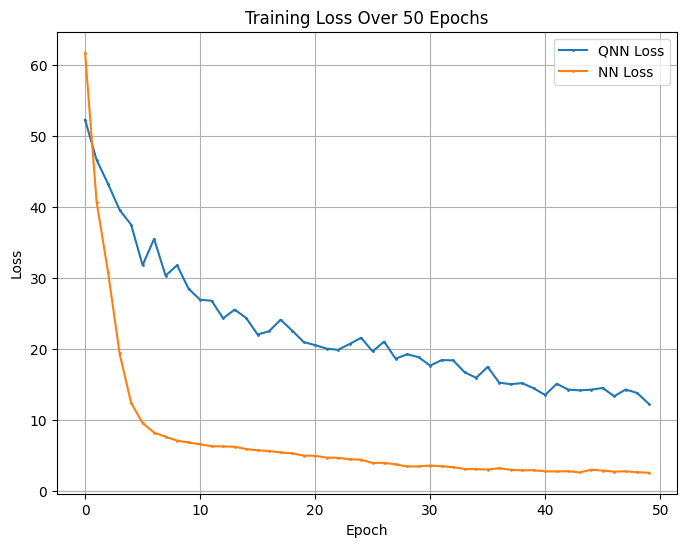

In [14]:
def plot_both(losses: list[list[float]]):
    # Get floats from tensor objects.
    _ = plt.figure(figsize=(8, 6))
    qnn_losses, nn_losses = losses
    plt.rcParams["lines.markersize"] = 1
    plt.plot(qnn_losses, marker="o", label="QNN Loss")
    plt.plot(nn_losses, marker="o", label="NN Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training Loss Over {len(losses[0])} Epochs")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_both([experiment["12_qubits"]["loss"], losses_classical])

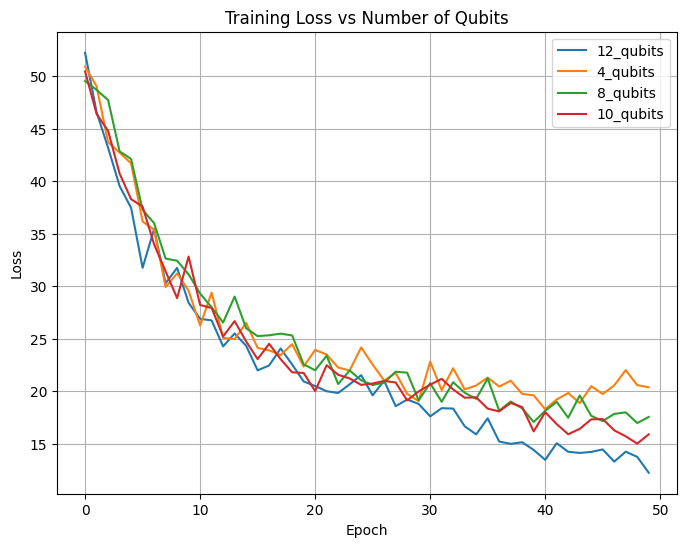

In [15]:
def plot_all(experiment_data: dict):
    _ = plt.figure(figsize=(8, 6))
    plt.rcParams["lines.markersize"] = 1
    runs = experiment_data.keys()
    for run in runs:
        loss = experiment_data[run]["loss"]
        plt.plot(loss, label=run)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training Loss vs Number of Qubits")
    plt.grid(True)
    plt.legend()
    plt.show()


plot_all(experiment)

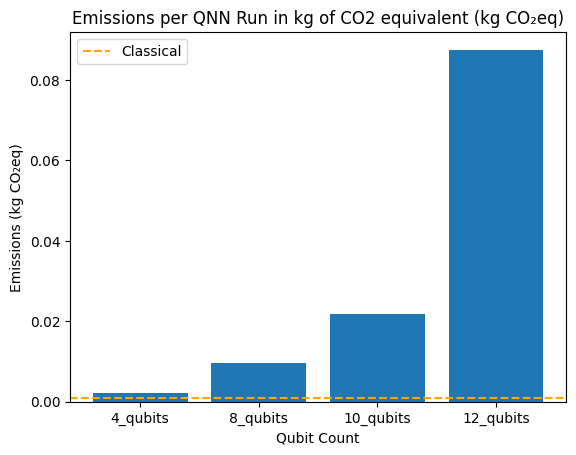

In [16]:
def plot_emissions(experiment_data: dict):
    runs = list(experiment_data.keys())
    maximum_observed_classical_co2_from_wandb = 0.001
    emissions = [experiment_data[run]["emissions"] for run in runs]

    emissions = emissions[1:] + [emissions[0]]  # bad code but we ran out of time   
    runs = runs[1:] + [runs[0]] 

    plt.bar(runs, emissions)
    plt.axhline(y=maximum_observed_classical_co2_from_wandb, color='orange', linestyle='--', label='Classical')
    plt.legend()
    plt.xlabel("Qubit Count")
    plt.ylabel("Emissions (kg CO₂eq)")
    plt.title("Emissions per QNN Run in kg of CO2 equivalent (kg CO₂eq)")

    plt.show()


plot_emissions(experiment)

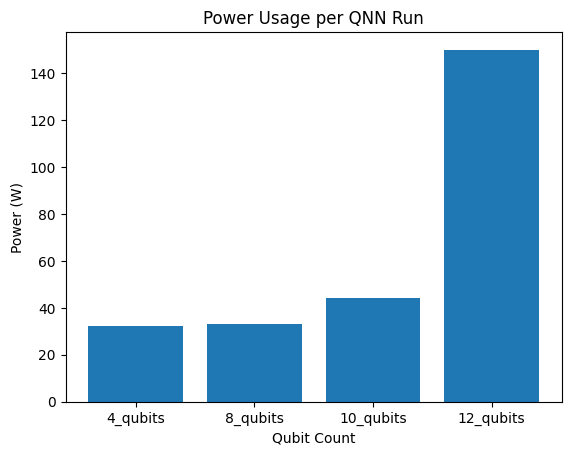

In [17]:
power_data_from_wandb = {
    "4_qubits": 32,
    "8_qubits": 33,
    "10_qubits": 44,
    "12_qubits": 150,
}


def plot_energy_usage(experiment_data: dict):
    runs = list(experiment_data.keys())
    energy_usage = experiment_data.values()

    plt.bar(runs, energy_usage)
    plt.xlabel("Qubit Count")
    plt.ylabel("Power (W)")
    plt.title("Power Usage per QNN Run")

    plt.show()


plot_energy_usage(power_data_from_wandb)

Fitted a=0.0000, b=5.4753, c=0.0316


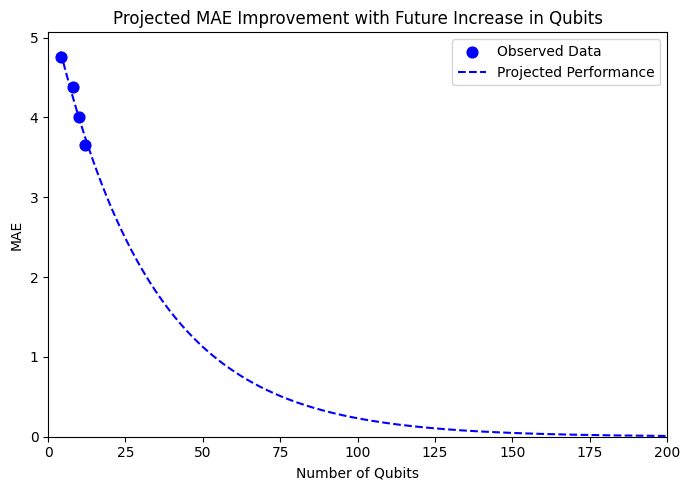

In [18]:
def plot_projected_perf(experiment_data: dict):

    """Here we use observed data to justify further improvements based on 
    forecasted increases in available qubits."""

    run_data = experiment.values()

    x_qubits = np.array([4, 8, 10, 12], dtype=float)
    y_mae = np.array(sorted([run["mae"] for run in run_data], reverse=True), dtype=float)


    def positive_exp_decay(x, log_a, log_b, log_c):
        a = np.exp(log_a)
        b = np.exp(log_b)
        c = np.exp(log_c)
        return a + b * np.exp(-c * x)

    p0 = [np.log(0.5), np.log(0.2), np.log(0.1)]
    params, cov = curve_fit(positive_exp_decay, x_qubits, y_mae, p0=p0)

    log_a_fit, log_b_fit, log_c_fit = params
    a_fit = np.exp(log_a_fit)
    b_fit = np.exp(log_b_fit)
    c_fit = np.exp(log_c_fit)

    print(f"Fitted a={a_fit:.4f}, b={b_fit:.4f}, c={c_fit:.4f}")

    x_range = np.linspace(x_qubits.min(), 200, 300)
    y_fit   = positive_exp_decay(x_range, log_a_fit, log_b_fit, log_c_fit)

    plt.figure(figsize=(7,5))

    plt.scatter(x_qubits, y_mae, color='blue', marker='o', s=60,
                label='Observed Data')

    plt.plot(x_range, y_fit, color='blue', linestyle='--',
            label='Projected Performance')

    plt.xlim(0, 200)
    plt.ylim(bottom=0)
    plt.xlabel('Number of Qubits')
    plt.ylabel('MAE')
    plt.title('Projected MAE Improvement with Future Increase in Qubits')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_projected_perf(experiment_data=experiment)